In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [32]:
#Load data
IMG_SIZE=(224,224)
BATCH_SIZE=32
DATA_DIR='/content/kag_risk_factors_cervical_cancer.csv'

In [33]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Data type of train_images: uint8
Data type of test_images: uint8
Minimum pixel value in train_images: 0
Maximum pixel value in train_images: 255
Unique labels and their counts in train_labels:
Label 0: 5923
Label 1: 6742
Label 2: 5958
Label 3: 6131
Label 4: 5842
Label 5: 5421
Label 6: 5918
Label 7: 6265
Label 8: 5851
Label 9: 5949


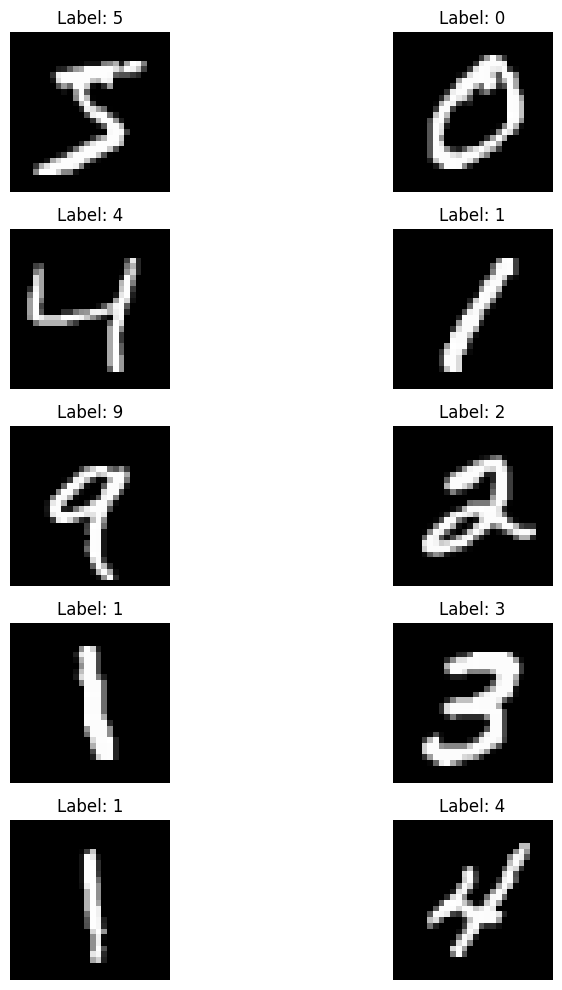

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Print the data type of the loaded image arrays
print(f"Data type of train_images: {train_images.dtype}")
print(f"Data type of test_images: {test_images.dtype}")

# 2. Print the minimum and maximum pixel values in train_images
print(f"Minimum pixel value in train_images: {np.min(train_images)}")
print(f"Maximum pixel value in train_images: {np.max(train_images)}")

# 3. Print the unique values and their counts in train_labels
unique_labels, counts = np.unique(train_labels, return_counts=True)
print("Unique labels and their counts in train_labels:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

# 4. Display a few example images from the training set
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
# Reshape the images to include a channel dimension
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Convert data type to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Reshaped training images shape: {train_images.shape}")
print(f"Reshaped test images shape: {test_images.shape}")
print(f"Data type of train_images after conversion: {train_images.dtype}")
print(f"Data type of test_images after conversion: {test_images.dtype}")
print(f"Minimum pixel value in train_images after normalization: {np.min(train_images)}")
print(f"Maximum pixel value in train_images after normalization: {np.max(train_images)}")

Reshaped training images shape: (60000, 28, 28, 1)
Reshaped test images shape: (10000, 28, 28, 1)
Data type of train_images after conversion: float32
Data type of test_images after conversion: float32
Minimum pixel value in train_images after normalization: 0.0
Maximum pixel value in train_images after normalization: 1.0


In [36]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print(f"Training images shape after split: {x_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Training labels shape after split: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

# Acknowledge the test set
print("The original test_images and test_labels will be used as the test set.")

Training images shape after split: (48000, 28, 28, 1)
Validation images shape: (12000, 28, 28, 1)
Training labels shape after split: (48000,)
Validation labels shape: (12000,)
The original test_images and test_labels will be used as the test set.


In [37]:
# Apply one-hot encoding to the labels
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

# Print the shapes of the one-hot encoded labels
print(f"Shape of one-hot encoded training labels: {y_train_one_hot.shape}")
print(f"Shape of one-hot encoded validation labels: {y_val_one_hot.shape}")
print(f"Shape of one-hot encoded test labels: {test_labels_one_hot.shape}")

Shape of one-hot encoded training labels: (48000, 10)
Shape of one-hot encoded validation labels: (12000, 10)
Shape of one-hot encoded test labels: (10000, 10)


In [38]:
# 1. Define a data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomRotation(factor=0.02),
])


# 3. Create TensorFlow Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_one_hot))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels_one_hot))

# Apply augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 4. Batch and prefetch the datasets
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("TensorFlow Datasets created, batched, and prefetched.")
print(f"Training dataset element spec: {train_ds.element_spec}")
print(f"Validation dataset element spec: {val_ds.element_spec}")
print(f"Test dataset element spec: {test_ds.element_spec}")

TensorFlow Datasets created, batched, and prefetched.
Training dataset element spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))
Test dataset element spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))


In [39]:
# 1. Compute class weights
# The labels are one-hot encoded, so we need to get the original labels
y_train_original = np.argmax(y_train_one_hot, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_original),
    y=y_train_original
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

print("Computed class weights:")
print(class_weights_dict)

# These class weights will be used during model training

Computed class weights:
{0: np.float64(1.0109519797809603), 1: np.float64(0.8856088560885609), 2: np.float64(1.0033444816053512), 3: np.float64(0.9771986970684039), 4: np.float64(1.0287183883411917), 5: np.float64(1.111883252258513), 6: np.float64(1.012444631934191), 7: np.float64(0.9665726943213854), 8: np.float64(1.0232359837987637), 9: np.float64(1.0094637223974763)}


In [40]:
from tensorflow.keras import layers, models

# 1. Define a Convolutional Neural Network (CNN) model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 classes for MNIST digits
])

# 3. Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# 4. Train the compiled model
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=class_weights_dict # Apply the computed class weights
)

# 5. Store the training history (already stored in the 'history' variable)
print("Model training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8725 - loss: 0.4002 - val_accuracy: 0.9790 - val_loss: 0.0679
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9797 - loss: 0.0643 - val_accuracy: 0.9851 - val_loss: 0.0539
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9860 - loss: 0.0442 - val_accuracy: 0.9862 - val_loss: 0.0518
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9892 - loss: 0.0327 - val_accuracy: 0.9873 - val_loss: 0.0474
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9901 - loss: 0.0297 - val_accuracy: 0.9897 - val_loss: 0.0399
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9881 - val_loss: 0.0499
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9930 - loss: 0.0215 - val_accuracy: 0.9876 - val_loss: 0.0505
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9950 -

In [26]:
# 1. Load the quantized TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 2. Prepare the test data for evaluation

test_images_np = np.concatenate([x for x, y in test_ds], axis=0)
test_labels_one_hot_np = np.concatenate([y for x, y in test_ds], axis=0)


# 3. Evaluate the model
predictions = []
for i in range(len(test_images_np)):
    input_data = np.array([test_images_np[i]], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data[0])

predictions = np.array(predictions)

# Calculate accuracy
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot_np, axis=1)

accuracy = np.mean(predicted_labels == true_labels)

print(f"Test accuracy of the quantized model: {accuracy}")


Test accuracy of the quantized model: 0.9645


In [30]:
# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,968 (1.07 MB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,646 (729.09 KB)